<img style="float: left;" src="./images/PallenceAI-Final.png" width="800">

# Sentiment Analysis on IMDb Reviews: Deep Learning with Bag of Words 

<img style="float: left;" src="./images/imdb2.png" width="400">

### Import needed libraries 

In [1]:
# Basic Python packages for data wrangling
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pathlib import Path

#Tensorflow & Keras related packages
import tensorflow as tf
from tensorflow import keras
from keras import layers

from utils import plot_history

### Load IMDb Dataset Preloaded in Tensorflow

In [3]:
import tensorflow_datasets as tfds

# Imdb dataset can also be dowloaded directly from keras. 
# ..However in that dataset the sequences have already been encoded as integers.
# from tensorflow.keras.datasets import imdb

C:\Users\sridh\anaconda3\envs\tf2.10_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train, val, test = tfds.load(name="imdb_reviews",split=["train[:80%]", "train[80%:]", "test"],
                             as_supervised=True)

### Understanding the Data 

In [5]:
# Lets see how many sample reviews are there in each dataset
print (len(train))
print (len(val))
print (len(test))

20000
5000
25000


In [6]:
type(train) # Its already stored as a tensorflow tf.data.Dataset object

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [7]:
train

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
for element in train.take(1):
    print (element)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [9]:
for review,label in train.take(1):
    print (review)
    print (label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [10]:
# Batch the data

train_data = train.batch(32)
val_data = val.batch(32)
test_data = test.batch(32)

In [11]:
# lets look at the first batch of data

for reviews, labels in train_data.take(1):
    print ("Reviews shape", reviews.shape)
    print ("Labels shape", labels.shape, "\n")
    
    print ('First Review:', reviews[0].numpy().decode("utf-8"), "\n")
    print ('First Label:', labels[0].numpy())


Reviews shape (32,)
Labels shape (32,) 

First Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it. 

First Label: 0


In [12]:
# First select only the reviews from training data (which contains both reviews/labels) 
#...which we will vectorize into numeric format.

train_data_onlyreviews = train_data.map(lambda x,y : x) # given a tuple (x,y), output only x

<img style="float: left;" src="./images/vectorization.png" width="300">

### 1. Multihot & Unigram BOW

### Prepare the data

**Leveraging Text Vectorization Layer in Keras**

In [ ]:
# Keras has in built Text Vectorization layer that can standardize, tokenize, 
#...and convert to indices or token vectors

Text Vectorization in Keras by default
* converts to lower case
* removes punctuation
* split on whitepsace

In [13]:
# But we can choose other options and can provide custom functions for standardization, 
#...tokenization etc..

In [14]:
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization

max_tokens = 10000
text_vectorization = TextVectorization(
                                        max_tokens=max_tokens,
                                        output_mode = "multi_hot"
)

# By default TextVectorization in keras

When you set the max_tokens parameter in the TextVectorization layer, TensorFlow will limit the vocabulary to the most frequent max_tokens words in the training data. 

Frequency Count: The TextVectorization layer will first go through all the text data to count the frequency of each word.

Sorting by Frequency: It will then sort these words by their frequency in descending order.

Top N Selection: Finally, it selects the top max_tokens words to be included in the vocabulary.

The words that appear most frequently in the training dataset will be included in the vocabulary, while the less frequent words will be excluded.

In [15]:
# Vectorize the reviews
# apply text vectorization only on the training data reviews to index the vocabulary

text_vectorization.adapt(train_data_onlyreviews) 

In [16]:
# This is the vocabulary based on training data reviews. 
# Basically it selected 10,000 unique words based on their frequency

vocab = text_vectorization.get_vocabulary()  
vocab

['[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'you',
 'his',
 'are',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'so',
 'like',
 'her',
 'or',
 'just',
 'about',
 'if',
 'has',
 'out',
 'some',
 'there',
 'what',
 'good',
 'very',
 'when',
 'more',
 'she',
 'my',
 'even',
 'would',
 'up',
 'no',
 'which',
 'time',
 'only',
 'really',
 'story',
 'their',
 'had',
 'were',
 'see',
 'can',
 'me',
 'than',
 'we',
 'much',
 'well',
 'been',
 'get',
 'will',
 'also',
 'do',
 'into',
 'people',
 'other',
 'because',
 'bad',
 'first',
 'great',
 'how',
 'most',
 'him',
 'dont',
 'then',
 'made',
 'movies',
 'make',
 'could',
 'films',
 'way',
 'any',
 'them',
 'after',
 'too',
 'characters',
 'think',
 'watch',
 'two',
 'many',
 'being',
 'character',
 'seen',
 'never',
 'little',
 'plot',
 'love',
 'where',
 'acting',


In [17]:
# Above u see '[UNK]' is used to represent an Out of Vocabulary token OOV token.

In [18]:
# Reviews will be converted into multihot

train_multihot_ugram = train_data.map(lambda x,y: (text_vectorization(x),y)) 
val_multihot_ugram = val_data.map(lambda x,y: (text_vectorization(x),y)) 
test_multihot_ugram = test_data.map(lambda x,y: (text_vectorization(x),y)) 

In [19]:
type(train_multihot_ugram)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [20]:
# lets look again at the first batch of data, now that reviews are converted into multihot vectors

for reviews, labels in train_multihot_ugram.take(1):
    print ("Reviews shape", reviews.shape)
    print ("Labels shape", labels.shape, "\n")
    
    print ('First Review:', reviews[0], "\n")
    print ('First Label:', labels[0].numpy())

Reviews shape (32, 10000)
Labels shape (32,) 

First Review: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(10000,), dtype=float32) 

First Label: 0


In [21]:
# Lets convert them into a table to understand how the reviews look in this multihot format.

for reviews, labels in train_multihot_ugram.take(1):
    # Convert tensor to numpy for easy to view
    reviews_np = reviews.numpy()

    # Create DataFrame
    df = pd.DataFrame(reviews_np, columns=vocab)
    break
df

,[UNK],the,and,a,of,to,is,in,it,i,...,dreaded,download,dock,distraught,discount,directorwriter,directionbr,dimwitted,dillon,digs
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Each review is now converted into a 10,000 dimensional vector with 1's and 0's 
# each unique word in the  vocabulary which we created previously are used as 
#...the 10000 column names  in the above table.

### Build the Model: Dense Network

In [23]:
# Reset the seeds for model initialization/training for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

**Dense Layers on top of the BOW-Multihot-10K vector for each input review**
* First dense layer has 16 Hidden Units
* Final dense layer has one unit which is for predicting the sentiment

<img style="float: left;" src="./images/ugram_dense.jpg" width="400">

In [24]:
hidden_units = 16

def model_ugram_dense(): 
    
    # Define Input shape
    inputs = keras.Input(shape = (max_tokens,)) 

    # Dense Hidden Layer
    x = layers.Dense(hidden_units, activation="relu")(inputs) 

    # Dropout Layer
    x = layers.Dropout(0.5)(x) 

    # Dense output Layer
    outputs = layers.Dense(1, activation="sigmoid")(x) 
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [25]:
model = model_ugram_dense()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Compile & Train the Model

In [26]:
model = model_ugram_dense()
path = Path("./models/model_ugram_dense.keras")

In [27]:
# Create a function to train and evaluate for convenience
def train_evaluate(model,path,train,val,test):
    
    # Call backs
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = path,
                                                       save_best_only=True) # Save only best model
    
    earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                                 restore_best_weights=True)
    callbacks = [checkpoint_cb,earlystop_cb]

    # Compile the model
    model.compile(optimizer="rmsprop", loss='binary_crossentropy',  metrics = ["accuracy"])
    
    # Train the model
    history = model.fit(train, validation_data = val, callbacks=callbacks, epochs=20)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test)
    
    return (history,test_accuracy)

In [28]:
(history_ugram_dense,test_accuracy_ugram_dense) = train_evaluate(model,path,
                                                                 train_multihot_ugram,
                                                                 val_multihot_ugram,
                                                                 test_multihot_ugram)

Epoch 1/20
625/625 [==============================] - 11s 14ms/step - loss: 0.4086 - accuracy: 0.8270 - val_loss: 0.2840 - val_accuracy: 0.8858
Epoch 2/20
625/625 [==============================] - 9s 14ms/step - loss: 0.2828 - accuracy: 0.8946 - val_loss: 0.2809 - val_accuracy: 0.8920
Epoch 3/20
625/625 [==============================] - 9s 15ms/step - loss: 0.2581 - accuracy: 0.9083 - val_loss: 0.2920 - val_accuracy: 0.8910
Epoch 4/20
625/625 [==============================] - 9s 15ms/step - loss: 0.2499 - accuracy: 0.9116 - val_loss: 0.3048 - val_accuracy: 0.8914
Epoch 5/20
625/625 [==============================] - 10s 17ms/step - loss: 0.2378 - accuracy: 0.9204 - val_loss: 0.3171 - val_accuracy: 0.8900
Epoch 6/20
625/625 [==============================] - 11s 17ms/step - loss: 0.2376 - accuracy: 0.9212 - val_loss: 0.3298 - val_accuracy: 0.8882
Epoch 7/20
782/782 [==============================] - 8s 11ms/step - loss: 0.2899 - accuracy: 0.8866


**Plot History**

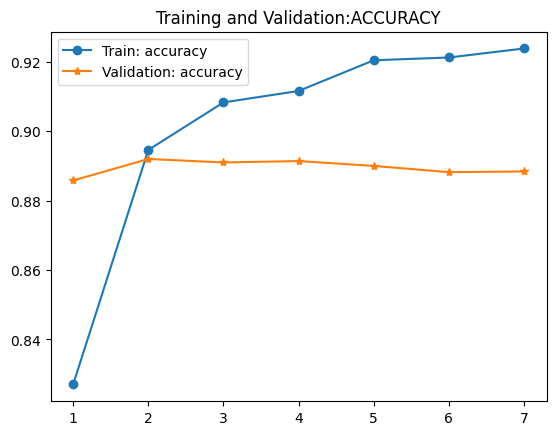

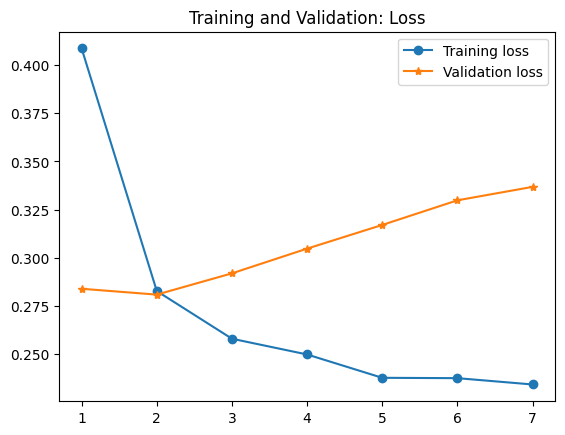

In [29]:
plot_history(history_ugram_dense,"accuracy")

In [30]:
# Mean absolute error with this simple 1 neuron dense model 
print (f"Accuracy on the test data set is {test_accuracy_ugram_dense}")

Accuracy on the test data set is 0.8865600228309631


### Inference: Make some predictions on sample reviews

In [31]:
# Lets make some predictions on test data
# whenever we want to make predictions (or inference) with the model, 
#...the input data needs to be preprocssed similar to training

# here test data has already been preprocessed in the same way...
# so lets use it..

**Predictions on Test Data**

In [32]:
for reviews, labels in test_multihot_ugram.take(1):
    print (reviews.shape)

(32, 10000)


In [33]:
# It will make predictions on all samples of test data and gives probabilities

test_probabilities = model.predict(test_multihot_ugram) 
test_probabilities

782/782 [==============================] - 6s 7ms/step


array([[0.94389665],
       [0.9774025 ],
       [0.00100609],
       ...,
       [0.0025428 ],
       [0.9298298 ],
       [0.9498134 ]], dtype=float32)

In [34]:
# Convert the probabilities into final label predictions
(test_probabilities >= 0.5).astype(int) 

array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [35]:
# Ground truth labels for the test data 

for review, label in test_multihot_ugram.take(1):
    print (label)

tf.Tensor([1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1], shape=(32,), dtype=int64)


## 2. MultiHot & Ngram: BOW

### Data prep

In [36]:
max_tokens = 10000
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=max_tokens,
    output_mode = "multi_hot"
)
# Vectorize the reviews
# Apply text vectorization on training data reviews to index the vocabulary
text_vectorization.adapt(train_data_onlyreviews) 

# reviews are converted into multihot
train_multihot_ngram = train_data.map(lambda x,y: (text_vectorization(x),y)) 
val_multihot_ngram = val_data.map(lambda x,y: (text_vectorization(x),y)) 
test_multihot_ngram = test_data.map(lambda x,y: (text_vectorization(x),y)) 

In [37]:
# Lets look at the vocabulary with ngrams=2

vocab = text_vectorization.get_vocabulary()
vocab

['[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'of the',
 'film',
 'on',
 'not',
 'you',
 'his',
 'are',
 'have',
 'be',
 'he',
 'one',
 'in the',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'so',
 'like',
 'her',
 'or',
 'just',
 'about',
 'if',
 'has',
 'out',
 'some',
 'there',
 'what',
 'this movie',
 'good',
 'very',
 'when',
 'more',
 'and the',
 'is a',
 'she',
 'my',
 'even',
 'would',
 'the film',
 'up',
 'no',
 'to the',
 'which',
 'time',
 'to be',
 'only',
 'really',
 'story',
 'their',
 'had',
 'were',
 'see',
 'the movie',
 'can',
 'this film',
 'me',
 'it is',
 'than',
 'we',
 'much',
 'well',
 'this is',
 'been',
 'get',
 'will',
 'also',
 'do',
 'into',
 'people',
 'other',
 'on the',
 'because',
 'bad',
 'in a',
 'first',
 'great',
 'how',
 'most',
 'him',
 'it was',
 'dont',
 'one of',
 'for the',
 'then',
 'made',
 'with the',
 'movies',
 'of a',

In [38]:
# Lets convert them into a table to understand how the reviews look like in this 
#...multihot & ngram format.

for reviews, labels in train_multihot_ngram.take(1):
    # Convert tensor to numpy for easy to view
    reviews_np = reviews.numpy()

    # Create DataFrame
    df = pd.DataFrame(reviews_np, columns=vocab)
    break
df

,[UNK],the,and,a,of,to,is,in,it,i,...,the blob,the awful,tender,tear,tap,survivors,superficial,succeeded,story or,splatter
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Each review is now converted into a 10,000 dimensional vector with 1's and 0's 
# each unique word in the  vocabulary which we created previously are used as 
#...column names (10,000) in the above table.

# now for each unique word we have used unigram & bigrams (ngrams=2)

### Build Model

In [40]:
# Reset the seeds for model initialization/training for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

**Dense Hidden Layer on top of the BOW-Multihot-10K bigram-vector for each review**

<img style="float: left;" src="./images/ugram_dense.jpg" width="400">

In [41]:
hidden_units = 16

def model_ngram_dense(): 
    inputs = keras.Input(shape = (max_tokens,)) # Define Input shape

    x = layers.Dense(hidden_units, activation="relu")(inputs) # Dense Hidden Layer

    x = layers.Dropout(0.5)(x) # Dropout Layer

    outputs = layers.Dense(1, activation="sigmoid")(x) # Dense output Layer
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [42]:
model = model_ngram_dense()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                160016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Compile & Train the Model

In [43]:
model = model_ngram_dense()
path = Path("./models/model_ngram_dense.keras")

In [44]:
(history_ngram_dense,test_accuracy_ngram_dense) = train_evaluate(model,path,
                                                                 train_multihot_ngram,
                                                                 val_multihot_ngram,
                                                                 test_multihot_ngram)

Epoch 1/20
625/625 [==============================] - 11s 17ms/step - loss: 0.3935 - accuracy: 0.8307 - val_loss: 0.2683 - val_accuracy: 0.8918
Epoch 2/20
625/625 [==============================] - 10s 17ms/step - loss: 0.2708 - accuracy: 0.9031 - val_loss: 0.2686 - val_accuracy: 0.8942
Epoch 3/20
625/625 [==============================] - 10s 16ms/step - loss: 0.2418 - accuracy: 0.9164 - val_loss: 0.2804 - val_accuracy: 0.8956
Epoch 4/20
625/625 [==============================] - 10s 15ms/step - loss: 0.2310 - accuracy: 0.9240 - val_loss: 0.2903 - val_accuracy: 0.8954
Epoch 5/20
625/625 [==============================] - 9s 15ms/step - loss: 0.2196 - accuracy: 0.9317 - val_loss: 0.3046 - val_accuracy: 0.8950
Epoch 6/20
782/782 [==============================] - 9s 12ms/step - loss: 0.2777 - accuracy: 0.8911


In [45]:
# Mean absolute error with this simple 1 neuron dense model 
print (f"Accuracy on the test data set is {test_accuracy_ngram_dense}")

Accuracy on the test data set is 0.8911200165748596


## 3. TFIDF: BOW

In [46]:
# tfidf = term_freq/doc_freq

### Data prep

In [48]:
max_tokens = 10000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode = "tf_idf"
)
# Vectorize the reviews
# apply text vectorization on training data reviews to index the vocabulary
text_vectorization.adapt(train_data_onlyreviews) 

vocab = text_vectorization.get_vocabulary()

# reviews are converted into multihot
train_tfidf = train_data.map(lambda x,y: (text_vectorization(x),y)) 
val_tfidf = val_data.map(lambda x,y: (text_vectorization(x),y)) 
test_tfidf= test_data.map(lambda x,y: (text_vectorization(x),y)) 



In [49]:
# Lets Take a peek at the transformed data again
for reviews, labels in train_tfidf.take(1):

    print ('First Review:', reviews[0], "\n")
    print ('First Label:', labels[0].numpy())

First Review: tf.Tensor(
[44.47641     1.3947983   0.71109307 ...  0.          0.
  0.        ], shape=(10000,), dtype=float32) 

First Label: 0


In [50]:
# Lets see the tfidf values in a table format of data to understand better
for reviews, labels in train_tfidf.take(1):
    # Convert tensor to numpy for easy to view
    reviews_np = reviews.numpy()

    # Create DataFrame
    df = pd.DataFrame(reviews_np, columns=vocab)
    break
df

,[UNK],the,and,a,of,to,is,in,it,i,...,dreaded,download,dock,distraught,discount,directorwriter,directionbr,dimwitted,dillon,digs
0,44.476410,1.394798,0.711093,1.420659,0.719636,0.000000,0.749767,2.279312,0.779969,1.670359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.119102,3.486996,2.844372,1.420659,3.598179,2.902317,0.749767,0.000000,0.779969,5.011076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,72.274170,6.973991,2.844372,3.551646,2.878543,3.627897,0.000000,1.519541,0.779969,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27.797756,3.486996,2.844372,3.551646,2.158907,0.725579,0.749767,0.759771,0.779969,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22.238205,4.881794,0.711093,1.420659,1.439272,1.451159,0.000000,0.759771,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,122.310127,7.671391,5.688745,6.392963,8.635630,1.451159,7.497674,6.078165,2.339907,0.835179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,350.251740,16.737579,8.533117,5.682634,10.074902,7.255793,3.748837,5.318395,1.559938,4.175897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,72.274170,4.881794,2.844372,2.841317,4.317815,1.451159,2.249302,0.000000,1.559938,0.835179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,44.476410,10.460987,5.688745,2.841317,3.598179,5.804635,2.999069,4.558624,3.899845,3.340717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,33.357307,2.789597,0.711093,3.551646,3.598179,2.176738,4.498604,0.000000,2.339907,0.835179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Removing the [UNK] token and its values from the data
train_tfidf = train_tfidf.map(lambda x,y: (x[:,1:],y)) 
val_tfidf = val_tfidf.map(lambda x,y: (x[:,1:],y)) 
test_tfidf= test_tfidf.map(lambda x,y: (x[:,1:],y)) 

In [52]:
# Lets see the tfidf values in a table format of data to understand better
for reviews, labels in train_tfidf.take(1):
    # Convert tensor to numpy for easy to view
    reviews_np = reviews.numpy()

    # Create DataFrame
    df = pd.DataFrame(reviews_np, columns=vocab[1:])
    break
df

,the,and,a,of,to,is,in,it,i,this,...,dreaded,download,dock,distraught,discount,directorwriter,directionbr,dimwitted,dillon,digs
0,1.394798,0.711093,1.420659,0.719636,0.000000,0.749767,2.279312,0.779969,1.670359,3.726158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.486996,2.844372,1.420659,3.598179,2.902317,0.749767,0.000000,0.779969,5.011076,2.235695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.973991,2.844372,3.551646,2.878543,3.627897,0.000000,1.519541,0.779969,0.000000,0.745232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.486996,2.844372,3.551646,2.158907,0.725579,0.749767,0.759771,0.779969,0.000000,0.745232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.881794,0.711093,1.420659,1.439272,1.451159,0.000000,0.759771,0.000000,0.000000,1.490463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7.671391,5.688745,6.392963,8.635630,1.451159,7.497674,6.078165,2.339907,0.835179,4.471390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,16.737579,8.533117,5.682634,10.074902,7.255793,3.748837,5.318395,1.559938,4.175897,1.490463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.881794,2.844372,2.841317,4.317815,1.451159,2.249302,0.000000,1.559938,0.835179,0.745232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,10.460987,5.688745,2.841317,3.598179,5.804635,2.999069,4.558624,3.899845,3.340717,2.235695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2.789597,0.711093,3.551646,3.598179,2.176738,4.498604,0.000000,2.339907,0.835179,2.235695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Build Model

In [53]:
# Reset the seeds for model initialization/training for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

**Dense Hidden Layer on top of the BOW-Multihot-10K TFIDF-vector for each review**

<img style="float: left;" src="./images/ugram_dense.jpg" width="400">

In [54]:
hidden_units = 16

def model_tfidf_dense(): 
    inputs = keras.Input(shape = (max_tokens-1,)) # Define Input shape

    x = layers.Dense(hidden_units, activation="relu")(inputs) # Dense Hidden Layer

    x = layers.Dropout(0.5)(x) # Dropout Layer

    outputs = layers.Dense(1, activation="sigmoid")(x) # Dense output Layer
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [55]:
model = model_tfidf_dense()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 9999)]            0         
                                                                 
 dense_8 (Dense)             (None, 16)                160000    
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________


### Compile & Train the Model

In [56]:
path = Path("./models/model_tfidf_dense.keras")

In [57]:
(history_tfidf_dense,test_accuracy_tfidf_dense) = train_evaluate(model,path,
                                                                 train_tfidf,
                                                                 val_tfidf,
                                                                 test_tfidf)

Epoch 1/20
625/625 [==============================] - 7s 10ms/step - loss: 0.4136 - accuracy: 0.8275 - val_loss: 0.2955 - val_accuracy: 0.8882
Epoch 2/20
625/625 [==============================] - 6s 9ms/step - loss: 0.2771 - accuracy: 0.9048 - val_loss: 0.3128 - val_accuracy: 0.8914
Epoch 3/20
625/625 [==============================] - 6s 9ms/step - loss: 0.2413 - accuracy: 0.9178 - val_loss: 0.3421 - val_accuracy: 0.8874
Epoch 4/20
625/625 [==============================] - 5s 8ms/step - loss: 0.2286 - accuracy: 0.9216 - val_loss: 0.3505 - val_accuracy: 0.8906
Epoch 5/20
625/625 [==============================] - 5s 7ms/step - loss: 0.2168 - accuracy: 0.9282 - val_loss: 0.3661 - val_accuracy: 0.8924
Epoch 6/20
782/782 [==============================] - 4s 4ms/step - loss: 0.3050 - accuracy: 0.8842


In [58]:
# Mean absolute error with this simple 1 neuron dense model 
print (f"Accuracy on the test data set is {test_accuracy_tfidf_dense}")

Accuracy on the test data set is 0.8841599822044373
